# Constellation Classifier
By Fardin Abdullah, Nicholas Foisy, Japmann Sarin

In [ ]:
import numpy as np 
import pandas as pd  
import os 
from pathlib import Path 
import glob

import seaborn as sns 
import matplotlib.pyplot as plt 

import tensorflow as tf  
from tensorflow.keras import layers
from tensorflow.keras import Model  
from tensorflow.keras.optimizers import RMSprop
from keras_preprocessing.image import ImageDataGenerator


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Defining important variables

In [ ]:
#defining list of labels
input_list = ["Aquarius", "Aries", "Cancer", "Cassiopeia", "Cygnus", "Pisces", "Scorpius", "Taurus", "Ursa_Minor"]
input_num = [i for i in range(len(input_list))]

#defining important parameters
pixel_count = 128 # this will be the size we change input images to to feed into the model

#this is where the data for the model will be selected
train_folder_path = Path('/content/gdrive/MyDrive/ConstellationClassifier/Dataset/Model_Data/Train')
test_path = Path('/content/gdrive/MyDrive/ConstellationClassifier/Dataset/Model_Data/Test')

In [ ]:
#In total, there are samples of images across 9 classes

#we can probably use a loop at some point to do this more concisely

aqu_path = Path('/content/gdrive/MyDrive/ConstellationClassifier/Dataset/Model_Data/Train/Aquarius')
ari_path = Path('/content/gdrive/MyDrive/ConstellationClassifier/Dataset/Model_Data/Train/Aries')
can_path = Path('/content/gdrive/MyDrive/ConstellationClassifier/Dataset/Model_Data/Train/Cancer')
cas_path = Path('/content/gdrive/MyDrive/ConstellationClassifier/Dataset/Model_Data/Train/Cassiopeia')
cyg_path = Path('/content/gdrive/MyDrive/ConstellationClassifier/Dataset/Model_Data/Train/Cygnus')
pis_path = Path('/content/gdrive/MyDrive/ConstellationClassifier/Dataset/Model_Data/Train/Pisces')
sco_path = Path('/content/gdrive/MyDrive/ConstellationClassifier/Dataset/Model_Data/Train/Scorpius')
tau_path = Path('/content/gdrive/MyDrive/ConstellationClassifier/Dataset/Model_Data/Train/Taurus')
umi_path = Path('/content/gdrive/MyDrive/ConstellationClassifier/Dataset/Model_Data/Train/Ursa_Minor')

aqu_images = aqu_path.glob('*.jpg')
ari_images = ari_path.glob('*.jpg')
can_images = can_path.glob('*.jpg')
cas_images = cas_path.glob('*.jpg')
cyg_images = cyg_path.glob('*.jpg')
pis_images = pis_path.glob('*.jpg')
sco_images = sco_path.glob('*.jpg')
umi_images = umi_path.glob('*.jpg')
tau_images = tau_path.glob('*.jpg')

images_list_train = [aqu_images, ari_images, can_images, cas_images, cyg_images, pis_images, sco_images, tau_images, umi_images]

#test_csv
aqu_path_test = Path('/content/gdrive/MyDrive/ConstellationClassifier/Dataset/Model_Data/Test/Aquarius')
ari_path_test = Path('/content/gdrive/MyDrive/ConstellationClassifier/Dataset/Model_Data/Test/Aries')
can_path_test = Path('/content/gdrive/MyDrive/ConstellationClassifier/Dataset/Model_Data/Test/Cancer')
cas_path_test = Path('/content/gdrive/MyDrive/ConstellationClassifier/Dataset/Model_Data/Test/Cassiopeia')
cyg_path_test = Path('/content/gdrive/MyDrive/ConstellationClassifier/Dataset/Model_Data/Test/Cygnus')
pis_path_test = Path('/content/gdrive/MyDrive/ConstellationClassifier/Dataset/Model_Data/Test/Pisces')
sco_path_test = Path('/content/gdrive/MyDrive/ConstellationClassifier/Dataset/Model_Data/Test/Scorpius')
tau_path_test = Path('/content/gdrive/MyDrive/ConstellationClassifier/Dataset/Model_Data/Test/Taurus')
umi_path_test = Path('/content/gdrive/MyDrive/ConstellationClassifier/Dataset/Model_Data/Test/Ursa_Minor')

aqu_images_test = aqu_path_test.glob('*.jpg')
ari_images_test = ari_path_test.glob('*.jpg')
can_images_test = can_path_test.glob('*.jpg')
cas_images_test = cas_path_test.glob('*.jpg')
cyg_images_test = cyg_path_test.glob('*.jpg')
pis_images_test = pis_path_test.glob('*.jpg')
sco_images_test = sco_path_test.glob('*.jpg')
umi_images_test = umi_path_test.glob('*.jpg')
tau_images_test = tau_path_test.glob('*.jpg')

images_list_test = [aqu_images_test, ari_images_test, can_images_test, cas_images_test, cyg_images_test, pis_images_test, sco_images_test, tau_images_test, umi_images_test]

test_csv = make_csv_with_image_labels(images_list_test,input_num)

num of Aquarius samples: 82.0
num of Aries samples: 82.0
num of Cancer samples: 140.0
num of Cassiopeia samples: 93.0
num of Cygnus samples: 84.0
num of Pisces samples: 78.0
num of Scorpius samples: 80.0
num of Taurus samples: 81.0
num of Ursa_Minor samples: 94.0


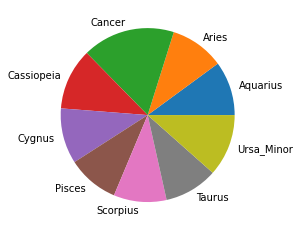

In [ ]:
#pretty visualization of train dataset

def make_csv_with_image_labels(images_list, labels_list):
    df = []
    for i in range(len(images_list)):
      for image in images_list[i]:
        df.append((image, i)) # adding each image of each class in dataframe df with corresponding class label 0, 1, 2, 3, 4
    df = pd.DataFrame(df, columns=["image_path", "label"], index = None) # converting into dataframe 
    df = df.sample(frac = 1).reset_index(drop=True) 
    return df  

train_csv = make_csv_with_image_labels(images_list_train, input_num) #outputs a dataframe with the image path of every image in classes 0 to 4 as well as their class number
train_csv.head()
#train_csv.iloc[0]['image_path'] #example of path stored

lengths = np.empty(len(input_list))
for num in input_num:
  lengths[num] = len(train_csv["label"][train_csv.label == num])
  print("num of", input_list[num], "samples:", lengths[num])

plt.pie(lengths, labels=input_list, shadow=False) 
plt.show()

## Data preprocessing

In [ ]:
X_train = [] #converting images to numpy arrays
for i in train_csv['image_path']:
  img = image.load_img(i, target_size=(400, 400), color_mode='rgb')
  img = img.resize((pixel_count,pixel_count))
  img = np.asarray(img)
  img = img/255
  X_train.append(img)
X_train = np.array(X_train)

#labels 
y_train = []

for i in train_csv['label']:
  y_train.append(i)

y_train = np.array(y_train)


In [ ]:
#X_test
X_test = []
for i in test_csv['image_path']:
  img = image.load_img(i, target_size=(400, 400), color_mode='rgb')
  img = img.resize((pixel_count,pixel_count))
  img = np.asarray(img)
  img = img/255
  X_test.append(img)
X_test = np.array(X_test)

#y_test
y_test = []

for i in test_csv['label']:
  y_test.append(i)

y_test = np.array(y_test)



## Building the Convolutional Neural Network

In [ ]:
cnn = Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(9, activation='softmax')
])

In [ ]:
cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Training the model

In [ ]:
cnn.fit(X_train, y_train, epochs=50)

Epoch 1/50
26/26 [==============================] - 16s 610ms/step - loss: 2.5342 - accuracy: 0.2052
Epoch 2/50
26/26 [==============================] - 16s 609ms/step - loss: 1.0120 - accuracy: 0.6941
Epoch 3/50
26/26 [==============================] - 16s 608ms/step - loss: 0.3509 - accuracy: 0.8956
Epoch 4/50
26/26 [==============================] - 16s 607ms/step - loss: 0.1528 - accuracy: 0.9545
Epoch 5/50
26/26 [==============================] - 16s 610ms/step - loss: 0.0645 - accuracy: 0.9791
Epoch 6/50
26/26 [==============================] - 16s 609ms/step - loss: 0.0393 - accuracy: 0.9828
Epoch 7/50
26/26 [==============================] - 16s 608ms/step - loss: 0.0272 - accuracy: 0.9865
Epoch 8/50
26/26 [==============================] - 16s 609ms/step - loss: 0.0207 - accuracy: 0.9828
Epoch 9/50
26/26 [==============================] - 16s 608ms/step - loss: 0.0239 - accuracy: 0.9840
Epoch 10/50
26/26 [==============================] - 16s 609ms/step - loss: 0.0218 - accura

In [350]:
#saving the model
cnn.save('./CNN_Model.h5')

##Testing the model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
# Helper libraries
import numpy as np
import matplotlib.pyplot as pl

In [ ]:
#y_pred
y_pred = []
outputs = cnn.predict(X_test)

for output in outputs:
  y_pred.append(np.argmax(output))



from sklearn.metrics import accuracy_score
print("Accuracy of CNN model on testing dataset", accuracy_score(y_test, y_pred))



Accuracy of CNN model on testing dataset 0.8


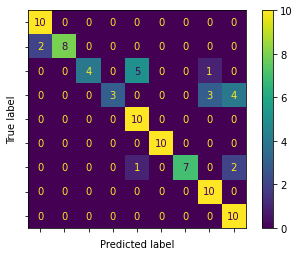

In [ ]:
#confustion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[""])
disp.plot()
plt.show()


## Predicting constellation classes with input images

0
Aquarius


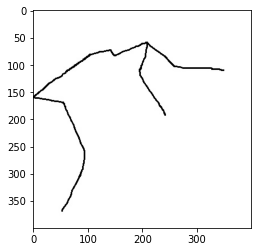

In [ ]:
#Attempting to predict Aquarius constellation

aqu_test = "/content/gdrive/MyDrive/ConstellationClassifier/Dataset/Model_Data/Predict/aqutest.jpg"
img_aqu = image.load_img(aqu_test, target_size=(400, 400), color_mode='rgb')

pl.imshow(img_aqu)
img_aqu = img_aqu.resize((pixel_count,pixel_count))
img_aqu= np.asarray(img_aqu)
img_aqu = img_aqu/255
img_aqu = img_aqu.reshape(1,pixel_count,pixel_count,3)
print(np.argmax(cnn.predict(img_aqu))) #0th index is max so it is Aquarius

print(input_list[np.argmax(cnn.predict(img_aqu))])




1
Aries


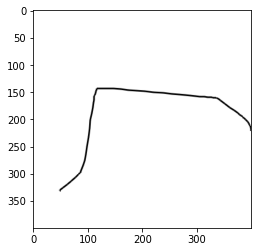

In [ ]:
#Attempting to predict Aries constellation

ari_test = "/content/gdrive/MyDrive/ConstellationClassifier/Dataset/Model_Data/Predict/ariestest.jpg"
img_ari = image.load_img(ari_test, target_size=(400, 400), color_mode='rgb')

pl.imshow(img_ari)
img_ari = img_ari.resize((pixel_count,pixel_count))
img_ari= np.asarray(img_ari)
img_ari = img_ari/255
img_ari = img_ari.reshape(1,pixel_count,pixel_count,3)
print(np.argmax(cnn.predict(img_ari))) #0th index is max so it is Aquarius

print(input_list[np.argmax(cnn.predict(img_ari))])

2
Cancer


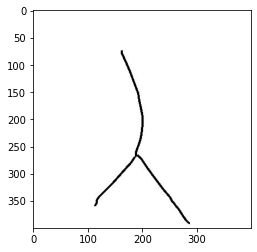

In [ ]:
#Attempting to predict Cancer constellation

can_test = "/content/gdrive/MyDrive/ConstellationClassifier/Dataset/Model_Data/Predict/cancertest.jpg"
img_can = image.load_img(can_test, target_size=(400, 400), color_mode='rgb')

pl.imshow(img_can)
img_can = img_can.resize((pixel_count,pixel_count))
img_can= np.asarray(img_can)
img_can = img_can/255
img_can = img_can.reshape(1,pixel_count,pixel_count,3)
print(np.argmax(cnn.predict(img_can))) #0th index is max so it is Aquarius

print(input_list[np.argmax(cnn.predict(img_can))])

3
Cassiopeia


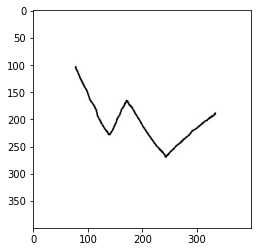

In [ ]:
#Attempting to predict Cassiopeia constellation

cass_test = "/content/gdrive/MyDrive/ConstellationClassifier/Dataset/Model_Data/Predict/casstest2.jpg"
img_cass = image.load_img(cass_test, target_size=(400, 400), color_mode='rgb')

plt.imshow(img_cass)
img_cass = img_cass.resize((pixel_count,pixel_count))
img_cass= np.asarray(img_cass)
img_cass = img_cass/255
img_cass = img_cass.reshape(1,pixel_count,pixel_count,3)
print(np.argmax(cnn.predict(img_cass))) #3rh index is max so it is cassiopeia

print(input_list[np.argmax(cnn.predict(img_cass))])

4
Cygnus


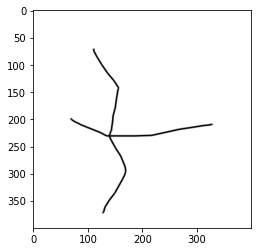

In [ ]:
#Attempting to predict Cygnus constellation

cyg_test = "/content/gdrive/MyDrive/ConstellationClassifier/Dataset/Model_Data/Predict/cygnustest.jpg"
img_cyg = image.load_img(cyg_test, target_size=(400, 400), color_mode='rgb')

plt.imshow(img_cyg)
img_cyg = img_cyg.resize((pixel_count,pixel_count))
img_cyg= np.asarray(img_cyg)
img_cyg = img_cyg/255
img_cyg = img_cyg.reshape(1,pixel_count,pixel_count,3)
print(np.argmax(cnn.predict(img_cyg))) #3rh index is max so it is 

print(input_list[np.argmax(cnn.predict(img_cyg))])

5
Pisces


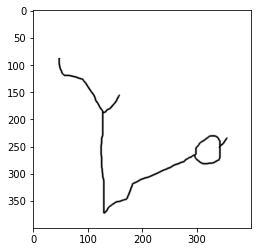

In [ ]:
#Attempting to predict Pisces constellation

pis_test = "/content/gdrive/MyDrive/ConstellationClassifier/Dataset/Model_Data/Predict/piscestest.jpg"
img_pis = image.load_img(pis_test, target_size=(400, 400), color_mode='rgb')

plt.imshow(img_pis)
img_pis = img_pis.resize((pixel_count,pixel_count))
img_pis= np.asarray(img_pis)
img_pis = img_pis/255
img_pis = img_pis.reshape(1,pixel_count,pixel_count,3)
print(np.argmax(cnn.predict(img_pis))) #3rh index is max so it is 

print(input_list[np.argmax(cnn.predict(img_pis))])

6
Scorpius


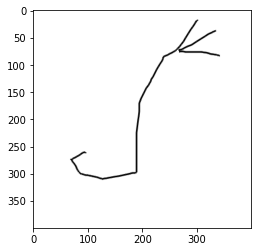

In [ ]:
#Attempting to predict Scorpio constellation

scr_test = "/content/gdrive/MyDrive/ConstellationClassifier/Dataset/Model_Data/Predict/scortest.jpg"
img_scr = image.load_img(scr_test, target_size=(400, 400), color_mode='rgb')

plt.imshow(img_scr)
img_scr = img_scr.resize((pixel_count,pixel_count))
img_scr = np.asarray(img_scr)
img_scr = img_scr/255

img_scr = img_scr.reshape(1,pixel_count,pixel_count,3)
print(np.argmax(cnn.predict(img_scr))) #4th index is max so it is a scorpio
print(input_list[np.argmax(cnn.predict(img_scr))])

7
Taurus


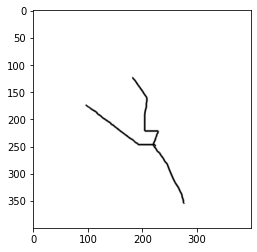

In [ ]:
#Attempting to predict Taurus constellation

tau_test = "/content/gdrive/MyDrive/ConstellationClassifier/Dataset/Model_Data/Predict/taurustest.jpg"
img_tau = image.load_img(tau_test, target_size=(400, 400), color_mode='rgb')

plt.imshow(img_tau)
img_tau = img_tau.resize((pixel_count,pixel_count))
img_tau= np.asarray(img_tau)
img_tau = img_tau/255
img_tau = img_tau.reshape(1,pixel_count,pixel_count,3)
print(np.argmax(cnn.predict(img_tau))) #3rh index is max so it is 

print(input_list[np.argmax(cnn.predict(img_tau))])

8
Ursa_Minor


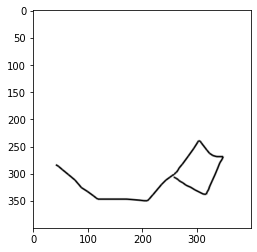

In [ ]:
#Attempting to predict Ursa Minor constellation

umi_test = "/content/gdrive/MyDrive/ConstellationClassifier/Dataset/Model_Data/Predict/ursaminortest.jpg"
img_umi = image.load_img(umi_test, target_size=(400, 400), color_mode='rgb')

plt.imshow(img_umi)
img_umi = img_umi.resize((pixel_count,pixel_count))
img_umi= np.asarray(img_umi)
img_umi = img_umi/255
img_umi = img_umi.reshape(1,pixel_count,pixel_count,3)
print(np.argmax(cnn.predict(img_umi))) #3rh index is max so it is 

print(input_list[np.argmax(cnn.predict(img_umi))])

##Conclusion

Overall, our model works pretty well :)

If you would like to contribute to our dataset, go to https://foisy.co/ to draw images!